In [3]:
###-- Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
##-- import library
import numpy as np 
import pandas as pd 
##-- Scikit-Learn
from sklearn.model_selection import train_test_split
##-- Matplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

import pickle
sns.set(style='white', context='notebook', palette='deep')

In [1]:
##-- Updata tensorflow 1.x -->  2.x
# For the current version: 
# !pip install --upgrade tensorflow

!pip install tensorflow-gpu 
!pip install tf-nightly 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
print(tf.__version__)
print(tf.keras.backend.floatx())
print(tf.test.gpu_device_name())

2.2.0-dev20200112
float32
/device:GPU:0


In [10]:
###---  Data PATH  ---###
datapath = "drive/My Drive/data_kfold/"

###-- Read Data
filename_train = "ukiyoe-dataset_kfold3_train.npz"
filename_validation = "ukiyoe-dataset_kfold3_validation.npz"

X_train = np.load(datapath+filename_train)["img"]
Y_train = np.load(datapath+filename_train)["lbl"]
X_test = np.load(datapath+filename_validation)["img"]
Y_test = np.load(datapath+filename_validation)["lbl"]

print(X_train.shape)

(2704, 224, 224, 3)


In [2]:
print(Y_train[0])
print(X_train[3][0].shape)
##-- check image (Error is occured, "np.float16")
plt.imshow(X_train[22], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-----------------------------------###
###       Cutout Random Erasing       ###
###-----------------------------------###
###-- Rondom Erasing --###
def eraser(input_img):
    ##-- Parameter
    p=0.5
    s_l=0.02
    s_h=0.4
    r_1=0.3
    r_2=1/0.3
    v_l=0
    # v_h=255
    v_h=1
    pixel_level=False
    ##--
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img
  
"""
    Batch dealing of Random Erasing
"""
def RandomErase( img_train ):
  x = []
  for i in range( len(img_train) ):
    tem = eraser( img_train[i] )
    x.append( tem )
    
  x = np.array(x)
  
  return x

In [13]:
###-- Cutout Random Erasing --##
X_train = RandomErase( X_train )
print( X_train.shape )

(2704, 224, 224, 3)


In [3]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[3], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
"""
    Data Augmentation
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import randint

##--(Number of data, Height, Width, Channels) 
def Data_Augmentation(image):
  """
      Set augmentation generator
  """
  ##-- Rondom flip
  rotation = ImageDataGenerator(rotation_range=20)
  ##-- Parallel Movement align to vertical direction.
  shift_vertical = ImageDataGenerator(height_shift_range=0.2)
  ##-- Parallel Movement align to horizontal direction.
  shift_horizontal = ImageDataGenerator(width_shift_range=0.2)
  ##-- Shear transformation; shera_range describes "angle".
  shear = ImageDataGenerator(shear_range=5)
  ##-- [-5.0, 5.0] の範囲でランダムに画素値に値を足す。
  noise = ImageDataGenerator(channel_shift_range=5.)
  ##-- [0.3, 1.0] の範囲でランダムに明度を変更する。
  brightness = ImageDataGenerator(brightness_range=[0.3, 1.0])
  ##--
  ret = []
  for i in range( 0, len(image) ):
    tem_img = np.reshape(image[i], [-1, image[i].shape[0], image[i].shape[1], image[i].shape[2]])
    ##-- Create random number between 0 - 3.
    rand_int = randint(4)
    if rand_int == 0:
      img_rot = rotation.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 1:
      img_rot = shift_vertical.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 2:
      img_rot = shift_horizontal.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 3:
      img_rot = shear.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = noise.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 5:
    #   img_rot = brightness.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = tem_img
    # #--
    # img_rot = next(img_rot)
    # #--
    ret.append( img_rot[0] )

  ret = np.array( ret )
  
  return ret

In [16]:
"""
    Data Augmentation and Inflation
"""
import gc

multiple = 1
img_ori = X_train.copy()
lbl_ori = Y_train.copy()
for i in range( multiple ):
  data_tem = Data_Augmentation( img_ori )
  X_train = np.append( X_train, data_tem, axis=0 )
  Y_train = np.append( Y_train, lbl_ori, axis=0 )

del img_ori, lbl_ori
gc.collect()

print(X_train.shape)
print(Y_train.shape)

(5408, 224, 224, 3)
(5408, 10)


In [4]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[458], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-- Shuffle dataset --###
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=99)

###---  Definition of each Model  ---###

学習およびモデルの保存

In [20]:
##-- Select the Model
# model = tf.keras.applications.ResNet50(
model = tf.keras.applications.ResNet50V2(
# model = tf.keras.applications.ResNet101(
# model = tf.keras.applications.ResNet152(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,  #--"max" is global max pooling, None is ordinary max pooling
    classes=10
    )

model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [21]:
##-- Define the optimizer
from tensorflow.keras import optimizers, losses
optimizer = optimizers.SGD(lr = 0.001, #--lr=0.01
                           momentum = 0.9, #--Default: 0.9
                           nesterov = True #--Default: False
                           )
# optimizer = optimizers.Adam(lr=0.01,
#                             # beta_1=0.9, beta_2=0.999, #--Defoalt values
#                             # amsgrad=True, #--AMSGrad
#                             )
##-- Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 35
batch_size = 64 #-- Default: 128, 64, 32
##-- Early stopping as es
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
##-- Temporary save
#--Ref. :  https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ja
import os
#-- ファイル名に(`str.format`を使って)エポック数を埋め込む
checkpoint_path = "drive/My Drive/jupyter/ProbSpace/ukiyoe/check_point/model3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 重みを5エポックごとに保存
    period=5)  #--period
##-- Run
history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_test,Y_test), #-- validation_split=0.2
                    verbose=2, 
                    # callbacks = [cp_callback]
                    # callbacks = [es]
                    )

Train on 5408 samples, validate on 676 samples
Epoch 1/35
5408/5408 - 39s - loss: 1.9467 - accuracy: 0.3190 - val_loss: 2.3714 - val_accuracy: 0.2175
Epoch 2/35
5408/5408 - 25s - loss: 1.4930 - accuracy: 0.4832 - val_loss: 2.9189 - val_accuracy: 0.2426
Epoch 3/35
5408/5408 - 25s - loss: 1.2906 - accuracy: 0.5335 - val_loss: 2.9808 - val_accuracy: 0.2973
Epoch 4/35
5408/5408 - 25s - loss: 1.1553 - accuracy: 0.5845 - val_loss: 1.6227 - val_accuracy: 0.4334
Epoch 5/35
5408/5408 - 25s - loss: 1.0558 - accuracy: 0.6317 - val_loss: 1.4679 - val_accuracy: 0.4660
Epoch 6/35
5408/5408 - 25s - loss: 0.9524 - accuracy: 0.6705 - val_loss: 1.0716 - val_accuracy: 0.6095
Epoch 7/35
5408/5408 - 25s - loss: 0.8569 - accuracy: 0.7147 - val_loss: 1.2924 - val_accuracy: 0.5828
Epoch 8/35
5408/5408 - 25s - loss: 0.7759 - accuracy: 0.7507 - val_loss: 1.5579 - val_accuracy: 0.5296
Epoch 9/35
5408/5408 - 25s - loss: 0.6812 - accuracy: 0.7779 - val_loss: 1.0826 - val_accuracy: 0.6435
Epoch 10/35
5408/5408 - 25

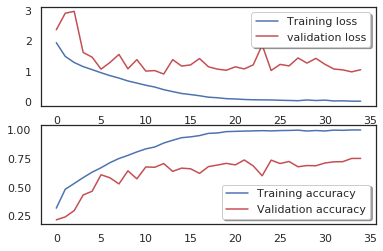

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

モデルの保存

In [0]:
###-- モデル全体を１つのHDF5ファイルに保存します。
datapath_model = "drive/My Drive/save_model/"
model.save(datapath_model+'model3.h5')

###-- Load model file
# model = tf.keras.models.load_model('model3.h5')
# model.summary()

テストデータを予測

In [0]:
###---  提出用データの読み込み  ---###

###--データの読み込み
def load(f):
    return np.load(f)['arr_0']
X_submit = load(datapath+"ukiyoe-test-imgs.npz")

###--型をint --> float変換する。
X_submit = X_submit.astype(np.float32)
###-- convert from [0:255] => [0.0:1.0]
X_submit = np.multiply(X_submit, 1.0 / 255.0)

print(X_submit.shape)

(397, 224, 224, 3)


In [0]:
###---  Prediction  ---###
predicts = np.argmax(model.predict(X_submit), axis=1)
predicts.shape

(397,)

In [2]:
###---  提出ファイル作成  ---###
submit = pd.DataFrame(data={"id": [], "y": []})
submit.id = list(range(1, predicts.shape[0]+1))
submit.y = predicts
submit.to_csv("submit.csv", index=False)

from google.colab import files
files.download("submit.csv")